# Import data from kaggle

In [ ]:
 !pip install kaggle

In [ ]:
 !mkdir ~/.kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo

100% 4.30G/4.31G [02:10<00:00, 33.6MB/s]
100% 4.31G/4.31G [02:10<00:00, 35.5MB/s]


In [ ]:
!ls -alh /content/pascalvoc-yolo.zip

-rw-r--r-- 1 root root 4.4G Oct 13  2020 /content/pascalvoc-yolo.zip


In [ ]:
!unzip -qq /content/pascalvoc-yolo.zip

In [ ]:
!ls -alh

total 4.4G
drwxr-xr-x 1 root root 4.0K Dec 17 14:13 .
drwxr-xr-x 1 root root 4.0K Dec 17 14:08 ..
-rw-r--r-- 1 root root 2.3K Oct 13  2020 100examples.csv
-rw-r--r-- 1 root root  186 Oct 13  2020 8examples.csv
drwxr-xr-x 4 root root 4.0K Dec 14 14:24 .config
drwx------ 6 root root 4.0K Dec 17 14:09 drive
-rw-r--r-- 1 root root  763 Oct 13  2020 generate_csv.py
-rw-r--r-- 1 root root 2.5K Oct 13  2020 get_data
drwxr-xr-x 2 root root 1.4M Dec 17 14:13 images
-rw-r--r-- 1 root root   76 Dec 17 14:09 kaggle.json
drwxr-xr-x 2 root root 648K Dec 17 14:13 labels
-rw-r--r-- 1 root root 4.4G Oct 13  2020 pascalvoc-yolo.zip
drwxr-xr-x 1 root root 4.0K Dec 14 14:24 sample_data
-rw-r--r-- 1 root root 112K Oct 13  2020 test.csv
-rw-r--r-- 1 root root 485K Oct 13  2020 train.csv


# Setup and Neccessary Imports

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.transforms import transforms
import torchvision
import torch.nn as nn
from math import sqrt
from torchvision.ops import nms,roi_pool
from tqdm.auto import tqdm

In [ ]:
class VOC_dataset(Dataset):
    def __init__(self, file_dir, img_dir, label_dir, img_size, transforms=None):
        # file_dir - Đường dẫn đến file chứa 2 cột
        # Cột 1 - tên file ảnh, Cột 2 - tên file nhãn
        self.annotations = pd.read_csv(file_dir)
        # img_dir - Đường dẫn đến thư mục chứa ảnh
        self.img_dir = img_dir
        # label_dir - Đường dẫn đến thư mục chứa nhãn
        # Mỗi file nhãn chứa class_number, x_center, y_center, width, height
        self.label_dir = label_dir
        self.img_size = img_size
        self.transforms = transforms

    def __getitem__(self, idx):
        # Load ảnh bằng tên file được chỉ định trong annotations
        img = Image.open(path.join(self.img_dir, self.annotations.iloc[idx, 0]))

        # Áp dụng các biến đổi đã chỉ định cho ảnh
        if (self.transforms):
            img = self.transforms(img)

        # Load và phân tích thông tin nhãn từ file nhãn tương ứng
        labels_path = path.join(self.label_dir, self.annotations.iloc[idx, 1])
        file_ref = open(labels_path, "r")
        final = []
        for lst in file_ref.readlines():
            example = []
            for label in lst.strip().split(" "):
                example.append(float(label))
            # Chuyển đổi nhãn thành định dạng [class_number, x_center, y_center, width, height]
            example = [int(example[0])] + [item * self.img_size for item in example[1:]]
            final.append(example)
        return img, final

    def __len__(self):
        # Độ dài được cứng cố cho mục đích kiểm thử; thông thường, nó sẽ trả về độ dài thực tế của tập dữ liệu
        return 10
        # return len(self.annotations)


In [ ]:
def my_collate(batch):
    # batch - Một danh sách các tuple đại diện cho (images, bboxes)

    # Chồng các ảnh thành một tensor
    images = torch.stack([item[0] for item in batch])

    # Tách các nhãn bbox
    bboxes = [item[1] for item in batch]

    # Trả về một danh sách gồm tensor ảnh và danh sách các nhãn bbox tương ứng
    return [images, bboxes]


In [ ]:
settings = {
    "img_size": 800,
    "pre_nms_top_n": 12000,
    "nms_threshold": 0.7,
    "post_nms_top_n": 2000,
    "pos_threshold": 0.7,
    "neg_threshold": 0.3,
    "num_RPN_samples": 256,
    "fg_threshold": 0.5,
    "bg_threshold_hi": 0.5,
    "bg_threshold_lo": 0.1,
    "num_classification_samples": 1000,  # Thay đổi
    "pool_size": 7,
    "ss_ratio": 16,
    "num_classes": 20,
    "feature_map_height": 50,
    "feature_map_width": 50,
    "feature_map_depth": 512,
    "anchor_ratios": [0.5, 1, 2],
    "anchor_scales": [8, 16, 32],
    "beta_rpn_loss": 1,  # Thay đổi
    "lambd_rpn_loss": 1,  # Thay đổi
    "beta_classifier_loss": 1,  # Thay đổi
    "lambd_classifier_loss": 1,  # Thay đổi
    "lr": 0.001  # Thay đổi
}


In [ ]:
batch_size = 1
mean_list = [0.485, 0.456, 0.406]
std_list = [0.229, 0.224, 0.225]

# Tạo một chuỗi biến đổi để chuẩn hóa và thay đổi kích thước ảnh
composed = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_list, std_list),
    transforms.Resize((settings["img_size"], settings["img_size"]))
])

# Tạo đối tượng của lớp VOC_dataset để đọc và xử lý dữ liệu
train_set = VOC_dataset("/content/100examples.csv",
                        "/content/images",
                        "/content/labels",
                        settings["img_size"],
                        composed)

# Sử dụng DataLoader để tạo các batch dữ liệu từ tập dữ liệu
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, collate_fn=my_collate)


In [ ]:
def plot_image(image, bboxes, mean_tensor, std_tensor, classes):
    # Chuẩn hóa ảnh trước khi hiển thị để tránh hiển thị ảnh không chính xác
    image = image * std_tensor + mean_tensor
    np_image = np.transpose(np.array(image), (1, 2, 0))

    plt.imshow(np_image)
    ax = plt.gca()

    for bbox in bboxes:
        x_center, y_center, width, height = bbox[1], bbox[2], bbox[3], bbox[4]
        x_tl, y_tl = (x_center - width/2), (y_center - height/2)

        # Thêm hình chữ nhật vào đồ thị với thông tin bbox
        ax.add_patch(matplotlib.patches.Rectangle((x_tl, y_tl), width, height, linewidth=1, edgecolor='r', facecolor='none'))

        # Hiển thị nhãn lớp bên trong hình chữ nhật
        plt.text(x_tl, y_tl, classes[int(bbox[0])], backgroundcolor='r')


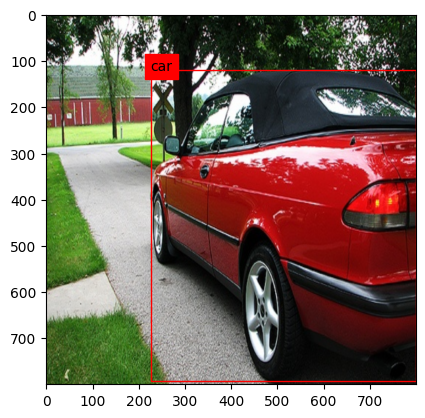

In [ ]:
import torch

# Giả sử mean_list và std_list đã được định nghĩa đúng ở nơi khác trong mã của bạn
mean_tensor = torch.tensor(mean_list).view(-1, 1, 1)
std_tensor = torch.tensor(std_list).view(-1, 1, 1)

# Số lớp đúng
num_classes = 21  # Đã cập nhật để bao gồm lớp 'background'
classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person',
           'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor',
           'background')

# Chọn một chỉ số hợp lệ, ví dụ: 0
idx = 0  # Hãy đảm bảo rằng giá trị này nằm trong phạm vi của số mẫu trong batch

# Chọn một ví dụ từ train_loader
try:
    example = next(iter(train_loader))

    # Đảm bảo rằng chỉ số được chọn nằm trong phạm vi hợp lệ
    if idx < 0 or idx >= len(example[0]):
        raise IndexError("Chỉ số 'idx' vượt quá giới hạn")

    image = example[0][idx]  # Ảnh tại chỉ số idx
    bboxes = example[1][idx]  # Bounding box tại chỉ số idx

    # Vẽ đồ thị ảnh với bounding box
    plot_image(image, bboxes, mean_tensor, std_tensor, classes)
except StopIteration:
    print("train_loader không có dữ liệu.")
except IndexError as e:
    print(e)


In [ ]:
def anchors_loc(x, y, anchor_ratios, anchor_scales, ss_ratio):
    '''
    Tính toán tọa độ của các anchor box dựa trên tọa độ (x, y) trên bản đồ đặc trưng,
    các tỉ lệ và quy mô của anchor.

    Inputs:
        x, y - Tọa độ từ bản đồ đặc trưng
        anchor_ratios - Danh sách các tỉ lệ chiều cao/chiều rộng
        anchor_scales - Danh sách các quy mô
        ss_ratio - Tỷ lệ lấy mẫu dưới, cho VGG16 thì là 16
    Output:
        anchors - len(anchor_scales) * len(anchor_ratios) x 4
    '''
    num_ratios = len(anchor_ratios)
    s = ss_ratio // 2
    x_ctr = (2 * x + 1) * s
    y_ctr = (2 * y + 1) * s
    anchors = []

    # Duyệt qua tất cả các tỷ lệ và quy mô để tính toán tọa độ anchor box
    for ratio_idx, ratio in enumerate(anchor_ratios):
        for scale_idx, scale in enumerate(anchor_scales):
            current = num_ratios * ratio_idx + scale_idx
            h = ss_ratio * scale * math.sqrt(ratio)
            w = ss_ratio * scale * math.sqrt(1 / ratio)
            anchors.append([x_ctr, y_ctr, w, h])

    return torch.tensor(anchors)

In [ ]:
def anchor_generation(h, w, device, anchor_ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32], ss_ratio=16):
    '''
    Tạo ra các anchor box tại từng tọa độ trên bản đồ đặc trưng.

    Inputs:
        h, w - Chiều cao và chiều rộng của bản đồ đặc trưng
        anchor_ratios - Danh sách các tỉ lệ chiều cao/chiều rộng của anchor
        anchor_scales - Danh sách các quy mô của anchor
        ss_ratio - Tỷ lệ lấy mẫu dưới, cho VGG16 thì là 16
    Output:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
    '''
    # Khởi tạo tensor anchors với kích thước phù hợp
    anchors = torch.zeros((h, w, len(anchor_ratios) * len(anchor_scales), 4))

    # Duyệt qua từng tọa độ trên bản đồ đặc trưng để tính toán anchors
    for y in range(h):
        for x in range(w):
            # Tính toán anchors cho từng tọa độ
            anchors[y, x] = anchors_loc(x, y, anchor_ratios, anchor_scales, ss_ratio)

    # Reshape tensor anchors để có kích thước (h*w*num_anchors x 4) và chuyển sang device
    return anchors.reshape(-1, 4).to(device)


In [ ]:
def bbox_transform_inv(anchors, rpn_bboxes):
    '''
    Chuyển đổi hệ số dự đoán (regression coefficients) của bounding boxes về dạng tọa độ tuyệt đối.

    Inputs:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
        rpn_bboxes - Tương tự như anchors nhưng chứa các hệ số hồi quy
    Output:
        transformed bboxes - Bounding boxes dự đoán, cùng kiểu và hình dạng với anchors,
                             có dạng [x_tl, y_tl, x_br, y_br]
    '''
    x_ctrs, delta_x = anchors[:, 0], rpn_bboxes[:, 0]
    y_ctrs, delta_y = anchors[:, 1], rpn_bboxes[:, 1]
    w, delta_w = anchors[:, 2], rpn_bboxes[:, 2]
    h, delta_h = anchors[:, 3], rpn_bboxes[:, 3]

    # Tính toán các tọa độ tuyệt đối của bounding boxes dự đoán
    pred_x_ctrs = (delta_x * w + x_ctrs).unsqueeze(-1)
    pred_y_ctrs = (delta_y * h + y_ctrs).unsqueeze(-1)
    pred_w = (torch.exp(delta_w) * w).unsqueeze(-1)
    pred_h = (torch.exp(delta_h) * h).unsqueeze(-1)

    pred_x_tls = pred_x_ctrs - 0.5 * pred_w
    pred_y_tls = pred_y_ctrs - 0.5 * pred_h
    pred_x_brs = pred_x_tls + pred_w
    pred_y_brs = pred_y_tls + pred_h

    # Kết quả là tensor chứa tọa độ tuyệt đối của bounding boxes dự đoán
    return torch.cat([pred_x_tls, pred_y_tls, pred_x_brs, pred_y_brs], axis=1)


In [ ]:
def clip_bboxes(transformed, img_size, device):
    '''
    Cắt (clip) tọa độ của bounding boxes để đảm bảo chúng nằm trong kích thước hình ảnh.

    Inputs:
        transformed - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
        img_size - Một giá trị nguyên đại diện cho chiều rộng và chiều cao của ảnh đầu vào
    Output:
        Clipped_bboxes - Bounding boxes đã được cắt, cùng kiểu và hình dạng với transformed
    '''
    zero_tensor = torch.tensor([0], device=device)
    size_tensor = torch.tensor([img_size], device=device)

    # Cắt tọa độ của bounding boxes để chúng nằm trong kích thước hình ảnh
    transformed[:, 0] = torch.maximum(zero_tensor, transformed[:, 0])
    transformed[:, 1] = torch.maximum(zero_tensor, transformed[:, 1])
    transformed[:, 2] = torch.minimum(size_tensor, transformed[:, 2])
    transformed[:, 3] = torch.minimum(size_tensor, transformed[:, 3])

    # Kết quả là tensor chứa bounding boxes đã được cắt
    return transformed


In [ ]:
def select_anchors(anchors, img_size):
    '''
    Chọn các anchor boxes dựa trên tọa độ của chúng và kích thước của hình ảnh đầu vào.

    Inputs:
        anchors - Một tensor có kích thước (-1 x 4)
        img_size - Một số nguyên
    Outputs:
        selected_anchors - Một tensor có kích thước (-1 x 4)
        a_idx - Một tensor có kích thước [-1]
            trong đó,
                Mỗi giá trị là chỉ số của các anchor được chọn
    '''
    # Tìm các chỉ số của anchor boxes thỏa mãn điều kiện về tọa độ
    a_idx = torch.where(torch.logical_and(
        torch.logical_and(anchors[:, 0] >= 0, anchors[:, 1] >= 0),
        torch.logical_and(anchors[:, 2] < img_size, anchors[:, 3] < img_size)
    ))[0]

    # Trả về tensor chứa các anchor boxes đã được chọn và các chỉ số của chúng
    return anchors[a_idx, :], a_idx

In [ ]:
def proposal_layer(anchors, rpn_scores, rpn_bboxes, img_size, pre_nms_top_n, nms_threshold, post_nms_top_n, device, mode='train'):
    '''
    Tính toán các proposal boxes dựa trên điểm số của RPN và hệ số hồi quy.

    Inputs:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
        rpn_scores - Một tensor có kích thước (-1 x 1)
        rpn_bboxes - Tương tự như anchors nhưng chứa các hệ số hồi quy
        img_size - Một số nguyên đại diện cho chiều rộng và chiều cao của ảnh đầu vào
        pre_nms_top_n, nms_threshold, post_nms_top_n - Các số nguyên
        device - Thiết bị (device) trên đó thực hiện tính toán (e.g., 'cuda' hoặc 'cpu')
        mode - Chế độ làm việc ('train' hoặc 'test')
    Output:
        scores - Một tensor có kích thước (-1,)
        proposals - Một tensor có kích thước (-1 x 4)
    '''
    transformed = bbox_transform_inv(anchors, rpn_bboxes)

    # if (mode=='test'):
    clipped_bboxes = clip_bboxes(transformed, img_size, device)
    # else:
    #    clipped_bboxes, selected_idx = select_anchors(transformed, img_size)

    # Sắp xếp điểm số theo thứ tự giảm dần và giữ lại chỉ số tương ứng
    scores, indices = rpn_scores.view(-1).sort(descending=True)

    # Lựa chọn chỉ số của các proposal boxes dựa trên số lượng cần giữ lại trước khi quá trình NMS
    indices = indices[:pre_nms_top_n]
    scores = scores[:pre_nms_top_n]

    # Lấy ra các bounding boxes tương ứng với các chỉ số đã chọn
    bboxes = clipped_bboxes[indices, :]

    # Thực hiện NMS để giữ lại các bounding boxes cuối cùng
    keep = nms(bboxes, scores, nms_threshold)
    m = min(keep.shape[0], post_nms_top_n)
    keep = keep[:m]

    # Lấy ra các proposal boxes và điểm số tương ứng
    proposals = bboxes[keep, :]
    scores = scores[keep]

    return scores, proposals

In [ ]:
def tl_br(anchors):
    '''
    Tính toán tọa độ của điểm trên cùng bên trái và điểm dưới cùng bên phải của bounding boxes.

    Inputs:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
    Output:
        anchors - Tương tự như "input" nhưng mỗi hàng biểu diễn x_tl, y_tl, x_br, y_br
    '''
    x = anchors[:, 0]
    y = anchors[:, 1]
    w = anchors[:, 2]
    h = anchors[:, 3]

    # Tính toán tọa độ của điểm trên cùng bên trái và điểm dưới cùng bên phải của bounding boxes
    x_tl = x - w / 2
    y_tl = y - h / 2
    x_br = x_tl + w
    y_br = y_tl + h

    # Kết quả là tensor chứa tọa độ x_tl, y_tl, x_br, y_br của bounding boxes
    return torch.cat([x_tl.unsqueeze(-1), y_tl.unsqueeze(-1), x_br.unsqueeze(-1), y_br.unsqueeze(-1)], axis=1)


In [ ]:
def get_iou_matrix(anchors, gt_bboxes, device):
    '''
    Tính ma trận IoU (Intersection over Union) giữa các anchor boxes và ground truth boxes.

    Inputs:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
            và mỗi hàng trong tensor biểu diễn dưới dạng [x_tl, y_tl, x_br, y_br]
        gt_bboxes - Một danh sách các danh sách
            trong đó,
                Mỗi danh sách nội bộ biểu diễn dưới dạng [class_number, x_ctr, y_ctr, width, height]
    Output:
        iou_matrix - Một tensor có kích thước (anchors.shape[0] x len(gt_bboxes))
    '''
    # anchors = tl_br(anchors)
    a_x1 = anchors[:, 0]
    a_y1 = anchors[:, 1]
    a_x2 = anchors[:, 2]
    a_y2 = anchors[:, 3]

    iou_matrix = torch.zeros((anchors.shape[0], len(gt_bboxes)), device=device)
    zero_tensor = torch.tensor([0], device=device)

    for gt_idx, gt_bbox in enumerate(gt_bboxes):
        _, gt_x_ctr, gt_y_ctr, gt_w, gt_h = gt_bbox
        gt_x1 = torch.tensor(gt_x_ctr - gt_w / 2, device=device)
        gt_y1 = torch.tensor(gt_y_ctr - gt_h / 2, device=device)
        gt_x2 = gt_x1 + gt_w
        gt_y2 = gt_y1 + gt_h

        # Tính toán diện tích của phần giao nhau và phần hợp của bounding boxes
        x1 = torch.maximum(a_x1, gt_x1)
        y1 = torch.maximum(a_y1, gt_y1)
        x2 = torch.minimum(a_x2, gt_x2)
        y2 = torch.minimum(a_y2, gt_y2)

        intersection = torch.maximum(zero_tensor, (x2 - x1)) * torch.maximum(zero_tensor, (y2 - y1))
        union = (a_x2 - a_x1) * (a_y2 - a_y1) + (gt_x2 - gt_x1) * (gt_y2 - gt_y1) - intersection

        # Tính toán giá trị IoU và lưu vào ma trận IoU
        iou_matrix[:, gt_idx] = intersection / (union + 1e-8)

    # Kết quả là ma trận IoU giữa các anchor boxes và ground truth boxes
    return iou_matrix


In [ ]:
def convert_select_anchors(anchors, img_size):
    '''
    Chuyển đổi tọa độ của anchor boxes và lựa chọn những anchor boxes nằm hoàn toàn trong kích thước hình ảnh.

    Inputs:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
        img_size - Một số nguyên
    Outputs:
        selected_anchors - Một tensor có kích thước (-1 x 4)
        a_idx - Một tensor có kích thước [-1]
            trong đó,
                Mỗi giá trị là chỉ số của các anchor được chọn
    '''
    # Chuyển đổi tọa độ của anchor boxes thành x_tl, y_tl, x_br, y_br
    anchors = tl_br(anchors)

    # Lựa chọn chỉ số của anchor boxes mà tất cả tọa độ của chúng đều nằm trong kích thước hình ảnh
    a_idx = torch.where(torch.logical_and(
        torch.logical_and(anchors[:, 0] >= 0, anchors[:, 1] >= 0),
        torch.logical_and(anchors[:, 2] < img_size, anchors[:, 3] < img_size)
    ))[0]

    # Trả về tensor chứa các anchor boxes đã được chuyển đổi và các chỉ số của chúng
    return anchors[a_idx, :], a_idx


In [ ]:
def anchor_target_layer(anchors, gt_bboxes, pos_threshold, neg_threshold, num_samples, img_size, rpn_scores, rpn_bboxes, device):
    '''
    Tính toán các mẫu mục tiêu cho mô hình RPN (Region Proposal Network).

    Inputs:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
        gt_bboxes - Một danh sách các danh sách
            trong đó,
                Mỗi danh sách nội bộ biểu diễn dưới dạng [class_number, x_ctr, y_ctr, width, height]
        pos_threshold - Một giá trị dấu chấm động để phân loại anchor boxes là trước mặt
        neg_threshold - Một giá trị dấu chấm động để phân loại anchor boxes là nền
        num_samples - Một số nguyên đại diện cho kích thước của mini-batch
        img_size - Một số nguyên đại diện cho chiều rộng và chiều cao của ảnh đầu vào
        rpn_scores - Một tensor có kích thước (-1 x 1)
    Outputs:
        foreground_samples - Một tensor có kích thước (-1 x 10),
            trong đó,
                Mỗi hàng biểu diễn dưới dạng [1, foreground_prob, gt_tx, gt_ty, gt_tw, gt_th, tx, ty, tw, th]
        background_samples - Một tensor có kích thước (-1 x 2),
            trong đó,
                Mỗi hàng biểu diễn dưới dạng [0, foreground_prob]
    '''
    # Chuyển đổi danh sách thành tensor
    tensor_gt = torch.tensor(gt_bboxes, device=device)

    # Số mẫu trước mặt và nền theo số lớp
    num_class_samples = num_samples // 2

    # Loại bỏ các anchor boxes nằm ngoài ảnh
    s_anchors, s_idx = convert_select_anchors(anchors, img_size)

    # Lấy rpn_scores chỉ cho các anchor boxes đã chọn
    s_rpn_scores = rpn_scores[s_idx, :]

    # Lấy rpn_bboxes chỉ cho các anchor boxes đã chọn
    s_rpn_bboxes = rpn_bboxes[s_idx, :]

    # Tạo một khung để lưu thông tin lớp và hệ số hồi quy thực tế
    actual = -1 * torch.ones((s_anchors.shape[0], 10), device=device)

    # Lấy thông tin chồng chất của mỗi anchor đã chọn với mỗi gt bbox
    iou_matrix = get_iou_matrix(s_anchors, gt_bboxes, device)

    # Tìm các anchor loại A
    max_overlap_values = torch.max(iou_matrix, axis=0)[0].unsqueeze(0)
    anchor_idx, gt_idx = torch.where(iou_matrix == max_overlap_values)

    # Xây dựng tensor thực tế cho các trước mặt loại A
    actual[anchor_idx, 0] = 1
    actual[anchor_idx, 1] = s_rpn_scores[anchor_idx, 0]
    actual[anchor_idx, 2] = (tensor_gt[gt_idx, 1] - s_anchors[anchor_idx, 0]) / s_anchors[anchor_idx, 2]
    actual[anchor_idx, 3] = (tensor_gt[gt_idx, 2] - s_anchors[anchor_idx, 1]) / s_anchors[anchor_idx, 3]
    actual[anchor_idx, 4] = torch.log(tensor_gt[gt_idx, 3] / s_anchors[anchor_idx, 2])
    actual[anchor_idx, 5] = torch.log(tensor_gt[gt_idx, 4] / s_anchors[anchor_idx, 3])
    actual[anchor_idx, 6:] = s_rpn_bboxes[anchor_idx, :]

    # Tìm các anchor loại B
    s_anchor_overlaps = torch.max(iou_matrix, axis=1)[0].unsqueeze(-1)
    anchor_idx, gt_idx = torch.where(torch.logical_and(s_anchor_overlaps == iou_matrix, s_anchor_overlaps > pos_threshold))

    # Xây dựng tensor thực tế cho các trước mặt loại B
    actual[anchor_idx, 0] = 1
    actual[anchor_idx, 1] = s_rpn_scores[anchor_idx, 0]
    actual[anchor_idx, 2] = (tensor_gt[gt_idx, 1] - s_anchors[anchor_idx, 0]) / s_anchors[anchor_idx, 2]
    actual[anchor_idx, 3] = (tensor_gt[gt_idx, 2] - s_anchors[anchor_idx, 1]) / s_anchors[anchor_idx, 3]
    actual[anchor_idx, 4] = torch.log(tensor_gt[gt_idx, 3] / s_anchors[anchor_idx, 2])
    actual[anchor_idx, 5] = torch.log(tensor_gt[gt_idx, 4] / s_anchors[anchor_idx, 3])
    actual[anchor_idx, 6:] = s_rpn_bboxes[anchor_idx, :]

    # Tìm các anchor nền
    background_mask = (s_anchor_overlaps.squeeze(-1) < neg_threshold)
    anchor_idx = torch.where(background_mask == True)[0]

    # Xây dựng tensor thực tế cho các nền
    actual[anchor_idx, 0] = 0
    actual[anchor_idx, 1] = s_rpn_scores[anchor_idx, 0]

    # Tạo chỉ số cho mẫu trước mặt và nền
    (pos_idx,) = torch.where(actual[:, 0] == 1)
    (neg_idx,) = torch.where(actual[:, 0] == 0)
    pos = min(pos_idx.shape[0], num_class_samples)
    neg = min(neg_idx.shape[0], num_class_samples)
    pos_idx = pos_idx[:pos]
    neg_idx = neg_idx[:neg]

    # Tạo các mẫu trước mặt và nền
    foreground_samples = actual[pos_idx, :]
    background_samples = actual[neg_idx, :2]

    return foreground_samples, background_samples

In [ ]:
'''
anchors=torch.tensor([[2,2,2,2],[3,3,2,2],[-3,2,2,2],[501,0,3,4],[4,6,2,2],[2,2,2,2]])
gt_bboxes=[[0,2,2,2,2],[1,3,3,2,2]]
pos_threshold=0.7
neg_threshold=0.2
num_samples=256
img_size=500
rpn_scores=torch.tensor([[0.8],[0.44],[0.3],[0.2],[0.7],[0.9]])
rpn_bboxes=torch.tensor([[1,2,3,4],[4,3,2,1],[9,8,7,6],[3,5,8,9],[6,7,8,9],[1,8,0,1]],dtype=torch.float)
fs,bs=anchor_target_layer(anchors,gt_bboxes,pos_threshold,neg_threshold,num_samples,img_size,rpn_scores,rpn_bboxes,'cpu')
print(fs)
print(bs)
'''

"\nanchors=torch.tensor([[2,2,2,2],[3,3,2,2],[-3,2,2,2],[501,0,3,4],[4,6,2,2],[2,2,2,2]])\ngt_bboxes=[[0,2,2,2,2],[1,3,3,2,2]]\npos_threshold=0.7\nneg_threshold=0.2\nnum_samples=256\nimg_size=500\nrpn_scores=torch.tensor([[0.8],[0.44],[0.3],[0.2],[0.7],[0.9]])\nrpn_bboxes=torch.tensor([[1,2,3,4],[4,3,2,1],[9,8,7,6],[3,5,8,9],[6,7,8,9],[1,8,0,1]],dtype=torch.float)\nfs,bs=anchor_target_layer(anchors,gt_bboxes,pos_threshold,neg_threshold,num_samples,img_size,rpn_scores,rpn_bboxes,'cpu')\nprint(fs)\nprint(bs)\n"

In [ ]:
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super().__init__()
        # Định nghĩa một lớp convolutional 3x3 với 512 output channels
        self.conv = nn.Conv2d(in_channels, 512, 3, padding=1)
        # Định nghĩa một lớp convolutional 1x1 để dự đoán điểm số cho các anchor
        self.s1 = nn.Conv2d(512, num_anchors, 1)
        # Định nghĩa một lớp convolutional 1x1 để dự đoán offsets cho các anchor
        self.s2 = nn.Conv2d(512, num_anchors * 4, 1)
        # Định nghĩa hàm kích hoạt ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        # Áp dụng lớp convolutional và hàm kích hoạt ReLU
        x = self.relu(self.conv(x))
        # Dự đoán điểm số cho anchor sử dụng hàm kích hoạt sigmoid
        scores = torch.sigmoid(self.s1(x))
        # Dự đoán offsets cho anchor
        offsets = self.s2(x)
        return scores, offsets


In [ ]:
def weights_init(m):
    # Kiểm tra xem lớp m có phải là một lớp Conv2d hay không
    if (type(m) == nn.Conv2d):
        # Khởi tạo trọng số của lớp Conv2d theo phân phối chuẩn với trung bình là 0 và độ lệch chuẩn là 0.001
        nn.init.normal_(m.weight, mean=0, std=0.001)
        # Khởi tạo bias của lớp Conv2d thành 0
        nn.init.zeros_(m.bias)

In [ ]:
def convert_to_center(proposals):
    # Trích xuất tọa độ của góc trái trên và góc dưới phải của các proposal
    x_tl = proposals[:, 0]
    y_tl = proposals[:, 1]
    x_br = proposals[:, 2]
    y_br = proposals[:, 3]

    # Tính toán tọa độ của tâm (center) của các proposal
    x_ctr = ((x_tl + x_br) / 2).unsqueeze(-1)
    y_ctr = ((y_tl + y_br) / 2).unsqueeze(-1)

    # Tính toán chiều rộng và chiều cao của các proposal
    w = (x_br - x_tl).unsqueeze(-1)
    h = (y_br - y_tl).unsqueeze(-1)

    # Kết hợp tất cả các thông tin trên thành tensor mới biểu diễn tâm, chiều rộng và chiều cao
    return torch.cat([x_ctr, y_ctr, w, h], axis=1)


In [ ]:
def proposal_target_layer(proposals, gt_bboxes, fr_threshold, bg_threshold_hi, bg_threshold_lo, batch_size, num_classes, device):
    '''
    Inputs:
        proposals - Hộp được biến đổi và được cắt thành dạng [x_tl, y_tl, x_br, y_br],
            hình dạng - (-1 x 4)
        gt_bboxes - Một danh sách các danh sách
            trong đó,
                Mỗi danh sách nội bộ có dạng [nhãn lớp, x_ctr, y_ctr, chiều rộng, chiều cao]
        fr_threshold - Ngưỡng cho các mẫu trước cảnh báo (Mặc định: 0.5)
        bg_threshold_hi - Ngưỡng trên cho các mẫu nền (Mặc định: 0.5)
        bg_threshold_lo - Ngưỡng dưới cho các mẫu nền (Mặc định: 0.1)
        batch_size - Số lượng mẫu để tạo cho mạng phân loại (Mặc định: 128)
        num_classes - Một giá trị số nguyên
        device - Thiết bị trên đó các tensor sẽ được tạo

    Outputs:
        target_samples - Một tensor có hình dạng (-1 x 5)
            trong đó,
                Mỗi hàng có dạng [nhãn lớp, tx, ty, tw, th]
        sample_indices - Một tensor có hình dạng (-1 x 6)
            trong đó,
                Mỗi hàng có dạng [chỉ số mẫu, x_tl, y_tl, x_br, y_br]
    '''

    num_class_samples = batch_size // 2
    gt_tensor = torch.tensor(gt_bboxes, dtype=torch.float, device=device)
    samples = -1 * torch.ones((proposals.shape[0], 6), device=device)
    iou_matrix = get_iou_matrix(proposals, gt_bboxes, device)
    max_overlaps, gt_idx = torch.max(iou_matrix, axis=1)

    # Tìm mẫu trước cảnh báo
    fg_idx = torch.where(max_overlaps > fr_threshold)[0]
    samples[fg_idx, :] = 0
    samples[fg_idx, 0] = 1
    associated_gts_fg = gt_idx[fg_idx]
    samples[fg_idx, 1] = gt_tensor[associated_gts_fg, 0]

    # Tìm mẫu nền
    bg_idx = torch.where(torch.logical_and(max_overlaps < bg_threshold_hi, max_overlaps > bg_threshold_lo))[0]
    samples[bg_idx, :] = 0
    associated_gts_bg = gt_idx[bg_idx]
    samples[bg_idx, 1] = num_classes

    # Ghép các chỉ số
    indices = torch.cat([fg_idx, bg_idx], axis=0)
    associated_gts = torch.cat([associated_gts_fg, associated_gts_bg], axis=0)

    # Chuyển đổi đề xuất
    converted_proposals = convert_to_center(proposals)

    # Tính toán hệ số regression
    samples[indices, 2] = (gt_tensor[associated_gts, 1] - converted_proposals[indices, 0]) / converted_proposals[indices, 2]
    samples[indices, 3] = (gt_tensor[associated_gts, 2] - converted_proposals[indices, 1]) / converted_proposals[indices, 3]
    samples[indices, 4] = torch.log(gt_tensor[associated_gts, 3] / converted_proposals[indices, 2])
    samples[indices, 5] = torch.log(gt_tensor[associated_gts, 4] / converted_proposals[indices, 3])

    # Tạo mẫu trước cảnh báo và mẫu nền
    fg_samples_idx = torch.where(samples[:, 0] == 1)[0]
    bg_samples_idx = torch.where(samples[:, 0] == 0)[0]
    num_fgs = min(fg_samples_idx.shape[0], num_class_samples)
    num_bgs = min(bg_samples_idx.shape[0], num_class_samples)
    final_fgs_idx = fg_samples_idx[:num_fgs]
    final_bgs_idx = bg_samples_idx[:num_bgs]

    # Nối các mẫu trước cảnh báo và nền
    target_samples = torch.cat([samples[final_fgs_idx, 1:], samples[final_bgs_idx, 1:]], axis=0)

    # Tạo tensor với các chỉ số mẫu và đề xuất
    sample_indices = torch.cat([torch.arange(end=target_samples.shape[0], dtype=torch.float).view(-1, 1),
                                proposals[final_fgs_idx, :], proposals[final_bgs_idx, :]], axis=1)

    return target_samples, sample_indices

In [ ]:
'''
proposals=torch.tensor([[1,1,3,3],[2,1,4,3],[5,1,6,3],[0,1,3,3]])
gt_bboxes=[[1,2,2,2,2]]
samples,ROI=proposal_target_layer(proposals,gt_bboxes,0.5,0.5,0.1,128,20,'cpu')
print(samples)
print(ROI)
'''

"\nproposals=torch.tensor([[1,1,3,3],[2,1,4,3],[5,1,6,3],[0,1,3,3]])\ngt_bboxes=[[1,2,2,2,2]]\nsamples,ROI=proposal_target_layer(proposals,gt_bboxes,0.5,0.5,0.1,128,20,'cpu')\nprint(samples)\nprint(ROI)\n"

In [ ]:
def create_labels_with_mask(samples, num_classes, device):
    '''
    Input:
        samples - Một tensor có hình dạng - (-1 x 5)
    Outputs:
        mask - Một tensor có hình dạng - (-1 x 80)
        gts - Một tensor có hình dạng - (-1 x 81)
            trong đó,
                Giá trị đầu tiên là số lớp và 80 giá trị khác là các hệ số regression thực tế
    '''

    # Lấy chỉ số của lớp
    class_idx = samples[:, 0].type(torch.long)
    num_rows = samples.shape[0]

    # Khởi tạo tensor gts và mask
    gts = torch.zeros((num_rows, 1 + 4 * (num_classes + 1)), device=device)
    mask = torch.zeros((num_rows, 4 * (num_classes + 1)), device=device)

    # Điền giá trị lớp vào tensor gts
    gts[:, 0] = class_idx
    rows = torch.tensor(range(num_rows))

    # Tính chỉ số bắt đầu của mỗi lớp
    start_idx = class_idx * 4

    # Điền giá trị hệ số regression và tạo mask tương ứng
    gts[rows, start_idx + 1] = samples[:, 1]
    mask[rows, start_idx] = 1
    gts[rows, start_idx + 2] = samples[:, 2]
    mask[rows, start_idx + 1] = 1
    gts[rows, start_idx + 3] = samples[:, 3]
    mask[rows, start_idx + 2] = 1
    gts[rows, start_idx + 4] = samples[:, 4]
    mask[rows, start_idx + 3] = 1

    # Trả về tensor gts và mask
    return gts[:, :4 * num_classes + 1], mask[:, :4 * num_classes]


In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_channels, pool_size, num_classes):
        super().__init__()

        # Số chiều của tensor đầu vào khi được flat
        self.flat = in_channels * pool_size * pool_size

        # Linear layer 1 với đầu vào có số chiều là flat và đầu ra là 4096
        self.lin1 = nn.Linear(in_channels * pool_size * pool_size, 4096)

        # Linear layer 2 với đầu vào có số chiều là 4096 và đầu ra là 4096
        self.lin2 = nn.Linear(4096, 4096)

        # Hàm kích hoạt ReLU
        self.relu = nn.ReLU()

        # Linear layer cho dự đoán lớp, đầu ra có số chiều là num_classes+1
        self.score_layer = nn.Linear(4096, num_classes + 1)

        # Linear layer cho dự đoán hệ số regression, đầu ra có số chiều là 4*num_classes
        self.offset_layer = nn.Linear(4096, 4 * num_classes)

    def forward(self, x):
        # Flat tensor
        x = x.view(-1, self.flat)

        # Áp dụng Linear layer 1 và ReLU
        x = self.relu(self.lin1(x))

        # Áp dụng Linear layer 2 và ReLU
        x = self.relu(self.lin2(x))

        # Dự đoán điểm số cho từng lớp
        class_scores = self.score_layer(x)

        # Dự đoán hệ số regression
        offsets = self.offset_layer(x)

        # Trả về điểm số lớp và hệ số regression
        return class_scores, offsets


In [ ]:
class ClassifierLoss(nn.Module):
    def __init__(self, beta, lambd):
        super().__init__()

        # Hàm mất mát CrossEntropyLoss
        self.CEL = nn.CrossEntropyLoss()

        # Hàm mất mát SmoothL1Loss với tham số beta
        self.SmoothL1L = nn.SmoothL1Loss(beta=beta)

        # Hệ số lambda cho phần tử mất mát hồi quy
        self.lambd = lambd

    def forward(self, gts, mask, class_scores, offsets):
        # Tính mất mát lớp sử dụng CrossEntropyLoss
        class_loss = self.CEL(class_scores, gts[:, 0])

        # Tính mất mát hồi quy sử dụng SmoothL1Loss nhân với mask
        offset_loss = self.SmoothL1L(gts[:, 1:], offsets * mask)

        # Tổng hợp mất mát lớp và mất mát hồi quy với hệ số lambda
        return class_loss + self.lambd * offset_loss


In [ ]:
class Network(nn.Module):
    def __init__(self, settings, num_anchors, device):
        super().__init__()

        # Khởi tạo mô hình RPN (Region Proposal Network)
        self.RPN = RPN(settings["feature_map_depth"], num_anchors)
        self.RPN.apply(weights_init)

        # Các tham số và cài đặt khác từ settings
        self.img_size = settings["img_size"]
        self.pre_nms_top_n = settings["pre_nms_top_n"]
        self.nms_threshold = settings["nms_threshold"]
        self.post_nms_top_n = settings["post_nms_top_n"]
        self.pos_threshold = settings["pos_threshold"]
        self.neg_threshold = settings["neg_threshold"]
        self.num_RPN_samples = settings["num_RPN_samples"]
        self.fg_threshold = settings["fg_threshold"]
        self.bg_threshold_hi = settings["bg_threshold_hi"]
        self.bg_threshold_lo = settings["bg_threshold_lo"]
        self.num_classification_samples = settings["num_classification_samples"]
        self.pool_size = settings["pool_size"]
        self.ss_ratio = settings["ss_ratio"]
        self.num_classes = settings["num_classes"]

        # Khởi tạo mô hình Classifier
        self.classifier = Classifier(settings["feature_map_depth"], settings["pool_size"], self.num_classes)

        # Tạo anchors dựa trên thông số từ settings
        self.generated_anchors = anchor_generation(settings["feature_map_height"],
                                                   settings["feature_map_width"],
                                                   device,
                                                   settings["anchor_ratios"],
                                                   settings["anchor_scales"],
                                                   self.ss_ratio)

        # Thiết lập thiết bị
        self.device = device

    def forward(self, feature_map, gt_bboxes):
        # Tính toán dự đoán của RPN
        rpn_scores, rpn_bboxes = self.RPN(feature_map)
        rpn_scores = rpn_scores.view(-1, 1)
        rpn_bboxes = rpn_bboxes.view(-1, 4)

        # Tính toán anchor samples cho RPN
        foreground_samples, background_samples = anchor_target_layer(self.generated_anchors, gt_bboxes,
                                                                     self.pos_threshold, self.neg_threshold,
                                                                     self.num_RPN_samples, self.img_size,
                                                                     rpn_scores, rpn_bboxes, self.device)

        # Tính toán proposals
        _, proposals = proposal_layer(self.generated_anchors, rpn_scores,
                                      rpn_bboxes, self.img_size,
                                      self.pre_nms_top_n,
                                      self.nms_threshold, self.post_nms_top_n,
                                      self.device)

        # Tính toán samples cho Classifier
        samples, variable_sized_ROIs = proposal_target_layer(proposals, gt_bboxes,
                                                             self.fg_threshold, self.bg_threshold_hi,
                                                             self.bg_threshold_lo, self.num_classification_samples,
                                                             self.num_classes, self.device)

        # Tạo nhãn và mask cho samples
        gts, mask = create_labels_with_mask(samples, self.num_classes, self.device)

        # Roi pooling trên feature_map dựa trên variable_sized_ROIs
        fix_sized_ROIs = roi_pool(feature_map, variable_sized_ROIs,
                                  (self.pool_size, self.pool_size),
                                  self.ss_ratio)

        # Tính toán dự đoán của Classifier
        class_scores, final_offsets = self.classifier(fix_sized_ROIs)

        return foreground_samples, background_samples, gts, mask, class_scores, final_offsets

    def inference(self):
        pass

In [ ]:
class RPN_loss(nn.Module):
    def __init__(self, beta, lambd, device):
        super().__init__()

        # Thiết lập các tham số và hàm loss
        self.lambd = lambd
        self.smooth_l1 = nn.SmoothL1Loss(beta=beta)
        self.BCELoss = nn.BCELoss()
        self.device = device

    def forward(self, foreground_samples, background_samples):
        # Tạo nhãn cho các foreground và background samples
        foreground_scores = torch.ones(foreground_samples.shape[0], device=self.device)
        background_scores = torch.zeros(background_samples.shape[0], device=self.device)
        gt_scores = torch.cat([foreground_scores, background_scores], axis=0)

        # Tạo dự đoán scores từ samples
        pred_scores = torch.cat([foreground_samples[:, 1].view(-1), background_samples[:, 1].view(-1)], axis=0)

        # Tính toán loss cho classification dựa trên BCELoss
        loss_cls = self.BCELoss(pred_scores, gt_scores)

        # Tính toán loss cho regression dựa trên SmoothL1Loss
        loss_coords = self.smooth_l1(foreground_samples[:, 2:6], foreground_samples[:, 6:])

        # Tổng hợp loss classification và regression với trọng số
        return loss_cls + self.lambd * loss_coords


In [ ]:
# Kiểm tra xem có sử dụng được GPU không, nếu không thì sử dụng CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Tính số lượng anchors dựa trên tỉ lệ và quy mô của anchors trong cấu hình
num_anchors = len(settings["anchor_ratios"]) * len(settings["anchor_scales"])

# Tạo một feature extractor từ mô hình VGG16 được pretrained, giữ lại các tầng cho đến conv5_3
feature_extractor = torchvision.models.vgg16(pretrained=True).features[:30]
feature_extractor.eval()

# Di chuyển feature extractor lên thiết bị GPU hoặc CPU tùy thuộc vào lựa chọn
feature_extractor = feature_extractor.to(device)

# Tạo và di chuyển mô hình RPN và Classifier lên thiết bị GPU hoặc CPU
net = Network(settings, num_anchors, device).to(device)

# Khởi tạo hàm loss cho RPN
get_rpn_loss = RPN_loss(settings["beta_rpn_loss"], settings["lambd_rpn_loss"], device)

# Khởi tạo hàm loss cho Classifier
get_classifier_loss = ClassifierLoss(settings["beta_classifier_loss"], settings["lambd_classifier_loss"])

# Khởi tạo trình tối ưu hóa Adam cho các tham số của mô hình
optimizer = torch.optim.Adam(net.parameters(), lr=settings["lr"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 89.7MB/s]
